# Интернет-магазин компьютерных игр

# Описание проекта 

Из открытых источников доступны исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Цель проекта**: выявить определяющие успешность игры закономерности и спрогнозировать продажи на 2017 год. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**План проекта:**
- [Общая информация](#1)
- [Предобработка данных](#2)
- [Исследовательский анализ данных](#3)
- [Портрет пользователей](#4)
- [Проверка гипотез](#5)
- [Общий вывод](#6)

# Общая информация
<a id='1'></a>

Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
try:
    games = pd.read_csv('/datasets/games.csv')
except: 
    games = pd.read_csv('./games.csv')

In [3]:
# функция, которая будет выводить общую информацию о датафрейме
def data_info(data):
    print(data.info())
    print('Доля явных дубликатов:', data.duplicated().mean()*100)
    data.hist(figsize=(7,10));
    return data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
Доля явных дубликатов: 0.0


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


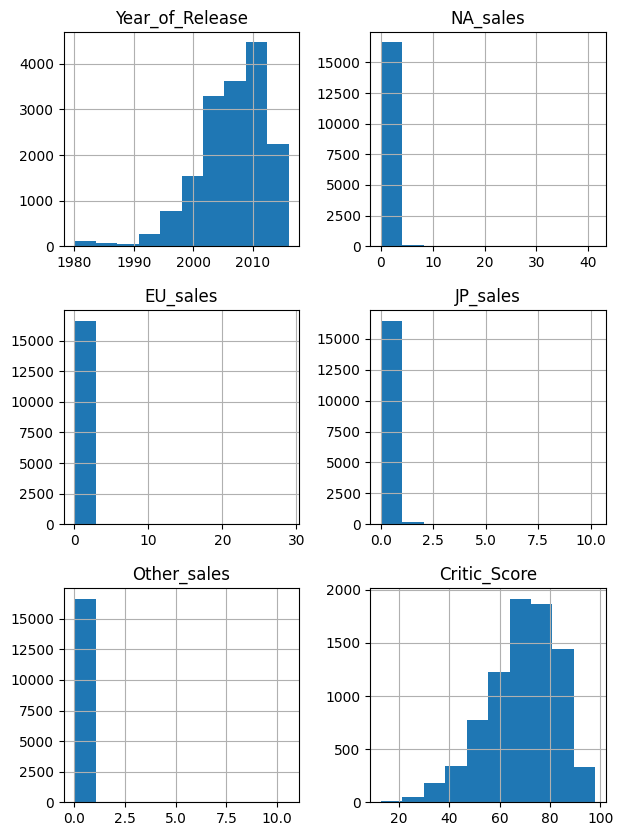

In [4]:
data_info(games)

Первичный обзор данных:
- нет явных дубликатов;
- пропуски в столбцах 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score' и 'Rating';
- нарушения в стиле заголовков;
- некорректный тип данных в стобцах 'Year_of_Release', 'User_Score' и 'Rating';
- в столбцах 'NA_sales', 'EU_sales', 'JP_sales' и 'Other_sales' есть аномальные значения;
- столбец 'Year_of_Release' охватывает слишком большой промежуток времени.

# Предобработка данных
<a id='2'></a>

Предобработку данных и дальнейшие исследования будем проводить с копией исходного датафрейма:

In [5]:
good_games = games

Приведем названия столбцов к нижнему регистру:

In [6]:
good_games.columns = good_games.columns.str.lower()
good_games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Обработка дубликатов

Первичный обзор данных показал отсутствие явных дубликтов. 

Проверим наличие неявных дубликатов в столбцах 'rating', 'platform' и 'genre':

In [7]:
good_games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [8]:
good_games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

Неявных дубликатов не обнаружено.

Проверим наличие игр с одинаковыми названием, платформой и годом выхода:

In [9]:
good_games.loc[ : , ['name', 'platform', 'year_of_release']].duplicated().mean()*100

0.011965300628178284

Удалим их:

In [10]:
good_games.drop_duplicates(subset = ['name', 'platform', 'year_of_release'], inplace = True)

Строчки, в которых были дубликаты остались, но теперь на месте 'name', 'platform', 'year_of_release' стоят значения nan. Удалим такие строчки на этапе обработки данных.

## Обработка аномальных значений 

In [11]:
good_games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16444.000000,16713.000000,16713.000000,16713.000000,16713.000000,8136.000000
mean,2006.485101,0.263409,0.145076,0.077625,0.047348,68.965954
std,5.876309,0.813647,0.503366,0.308871,0.186741,13.938153
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [12]:
q1 = np.percentile(good_games['na_sales'], 25)
q2 = np.percentile(good_games['na_sales'], 75)
iqr = st.iqr(good_games['na_sales'])
print(q1-1.5*iqr,q2+1.5*iqr)

-0.36 0.6


Анализ с помощью межкваритьного размаха (IQR) показал, что продажи выше 0.6 млн могут быть аномалиями, но удалять их не будем: в игровой индустрии большие объемы продаж могут быть нормой для поплуряных игр, а не выбросами.

## Обработка пропусков

Вычислим долю пропусков в каждом столбце:

In [13]:
pd.DataFrame(round(good_games.isna().mean().sort_values(ascending = False)*100,1)).style.background_gradient('coolwarm')

,0
critic_score,51.300000
rating,40.500000
user_score,40.100000
year_of_release,1.600000
name,0.000000
genre,0.000000
platform,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000


Пропуски в столбцах 'year_of_release', 'name' и 'genre' могут быть обусловлены сбоем при выгрузке данных. Таких строчек меньше 2%, поэтому их удаление не повлияет на корректность дальнейших выводов.

In [14]:
good_games = good_games.dropna (subset=['name', 'genre', 'year_of_release'])

---

Пропусков в 'critic_score', 'rating' и 'user_score' около половины. Скорее всего, информация по таким играм не найдена или пропущена намеренно. 

Заполнение пропусков средним или медианным значением сильно исказит дальнейшие выводы, но, с другой стороны, столбцы 'critic_score' и 'user_score' числовые, а из-за наличия значения NaN с ними можно работать только как с типом object. 

Пропуски в столбцах 'critic_score' и 'user_score' заполним значениями -10 и -1 соответственно. 

Пропуски в столбце с рейтингом ESRB, могут означать несколько вещей:
- Отсутствие рейтинга: В некоторых случаях у игры действительно может не быть рейтинга ESRB, например, если игра была выпущена без рейтинга или для рынка, где рейтинги ESRB не применяются.
- Региональные различия: Данные могут включать игры, которые были выпущены в регионах, где система ESRB не используется. Например, в Европе и Японии могут применяться другие рейтинговые системы.
- Недостаток данных: Пропуски могут быть результатом неполного набора данных или ошибок в сборе данных.

Рейтинг RP (Rating Pending, т.е. рейтинг на рассмотрении) обычно присваивается играм, которые еще не получили окончательного рейтинга. Однако в данном наборе данных, вероятно, пропуски не означают, что рейтинг будет определен позже, так как данные исторические и рассматривают игры, которые уже были выпущены.

Замена пропусков на 'Unknown' помогает учесть все эти возможные причины, и затем можно анализировать их как отдельную категорию. Это полезно для выявления, например, тенденций в играх без рейтинга: как они продаются по сравнению с играми с рейтингом, в каких регионах чаще встречаются пропуски.

In [15]:
good_games['rating'] = good_games['rating'].fillna('Unknown')
good_games['critic_score'] = good_games['critic_score'].fillna(-10)
good_games['user_score'] = good_games['user_score'].fillna(-1)

## Тип данных

Год выпуска - целое число, однако в общей информации о датафрейме тип столбца 'year_of_release' указан как float, а сами значения записаны как вещественные с 0 после точки. Приведем этот столбец к типу int:

In [16]:
good_games['year_of_release'] = good_games['year_of_release'].astype('int')

---

Оценка критиков варьируется от 0 до 100, а оценка пользователей  - от 0 до 10. Для более наглядного и удобного сравнения разделим значения из  столбца 'critic_score' на 10:

In [17]:
good_games['critic_score'] = good_games['critic_score']/10

---

Стобец 'user_score' имеет тип данных object по двум причинам: 
- наличие пропусков (уже заполнены значением -1)
- наличие строкового значения 'tbd', что значит to be determined. Заменим такие значения на -2 и приведем столбец к типу float.

In [18]:
good_games.loc[good_games['user_score']=='tbd', 'user_score'] = -2

In [19]:
good_games['user_score'] = good_games['user_score'].astype('float')

## Добавление новых столбцов 

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [20]:
good_games['total_sales'] = good_games['na_sales']+good_games['eu_sales']+good_games['jp_sales']+good_games['other_sales']

## Итоги предобработки 

In [21]:
good_games = good_games.reset_index(drop=True)

In [22]:
good_games.shape[0]/games.shape[0]

0.9838449111470113

In [23]:
print(good_games.info())
good_games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB
None


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,Unknown,31.38


Результаты предобработки данных:
- названия столбцов приведены к нижнему регистру;
- данные проверены на отсутствие неявных дубликатов;
- удалены игры с одинаковыми названием, платформой и годом выпуска;
- обработаны пропуски: заполнение пропусков средним или медианным значением сильно бы исказило дальнейшие выводы, но, с другой стороны, столбцы 'critic_score' и 'user_score' числовые, а из-за наличия значения NaN с ними можно было работать только как с типом object, поэтому пропуски в столбцах 'critic_score' и 'user_score' заполнили значениями -10 и -1 соответственно, а пропуски в столбце 'rating' заменили на 'Unknown'.
- изменили тип данных: столбец 'year_of_release' привели к типу int. В столбце 'user_score' заменили значения 'tbd'(to be determined) на -2 и привели к типу float;
- для более наглядного и удобного сравнения оценки критиков и пользователей разделили значения из  столбца 'critic_score' на 10;

В итоге, осталось 91.5% данных. 

# Исследовательский анализ данных
<a id='3'></a>

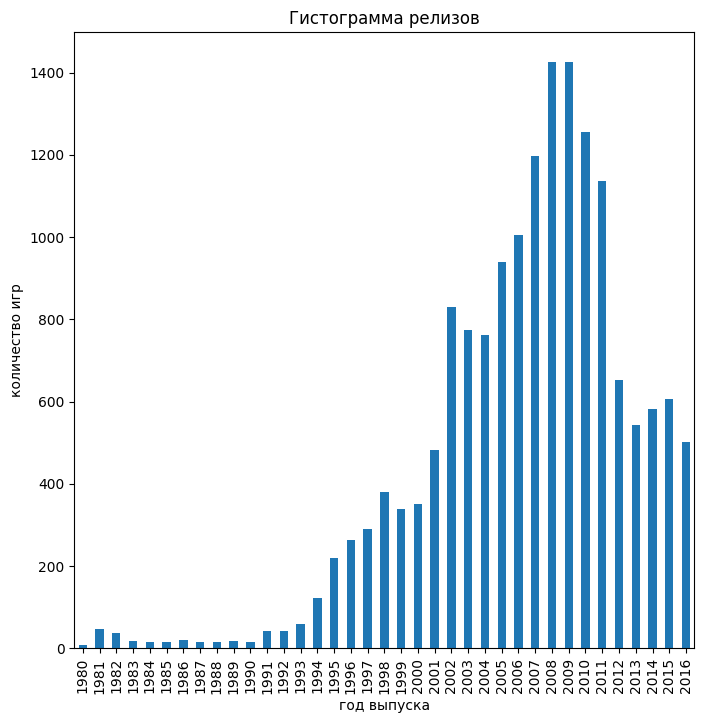

In [24]:
good_games['year_of_release'] .value_counts().sort_index().plot(kind = 'bar', title = 'Гистограмма релизов', ylabel = 'количество игр', xlabel = 'год выпуска', figsize=(8,8));

In [25]:
good_games['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

Больше всего игр выходило в 2007-2011 годах, после чего количество релизов пошло на спад.

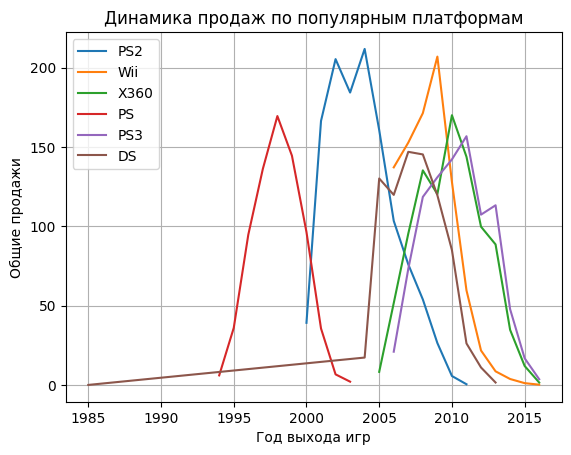

In [26]:
gr_games = good_games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
gr_best_games = gr_games.sort_values('total_sales', ascending = False).head(25)
#plt.figure(figsize=(10, 8.6))
for platform in gr_best_games['platform'].unique():
    platform_data = gr_games[gr_games['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], label=platform)

plt.xlabel('Год выхода игр')
plt.ylabel('Общие продажи')
plt.title('Динамика продаж по популярным платформам')
plt.legend()
plt.grid(True)
plt.show()

По графику видно, что 7-10 лет - характерный срок, за который появляются новые и исчезают старые платформы.

Стоит обратить внимание на платформу DS. Там всего 2 точки: 1985 и 2004, вряд ли игры не продавались 20 лет. Возможно это ошибка, так как в 1985 году этой платформы еще не существовало. 

Для прогнозирования продаж на 2017 год выберем акутальный период: с 2013 по 2016 год, так как продажа игр - динамично меняющаяся индустрия и есть риск взять в рассчет уже отжившие тренды.

In [27]:
actual_games = good_games[good_games['year_of_release']>=2013]

In [28]:
actual_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,9.7,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,9.7,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,Unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,9.7,8.3,M,12.62


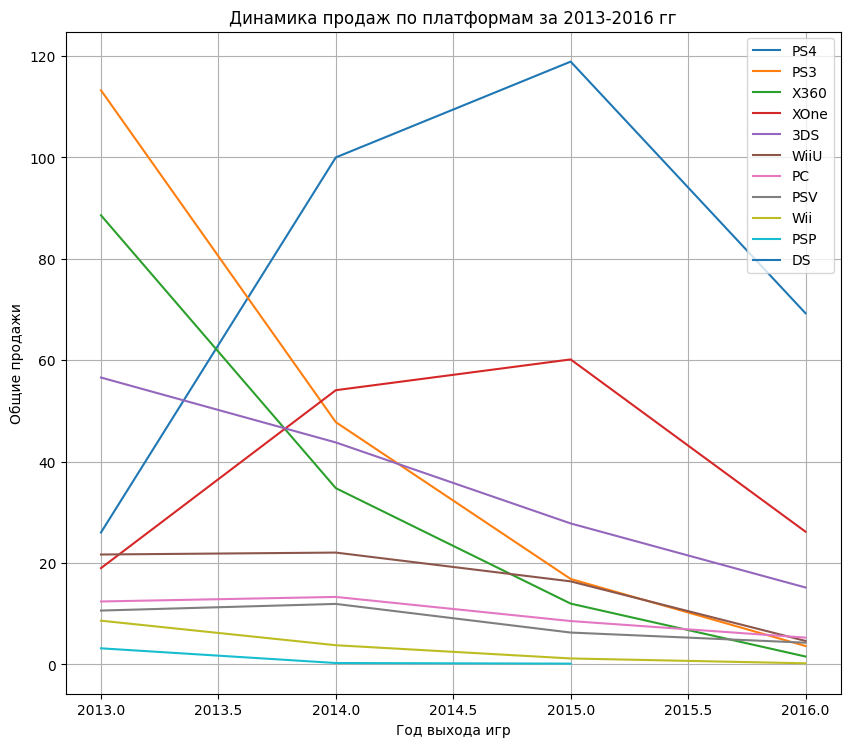

In [29]:
gr_games = actual_games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
gr_best_games = gr_games.sort_values('total_sales', ascending = False)
plt.figure(figsize=(10, 8.6))
for platform in gr_best_games['platform'].unique():
    platform_data = gr_games[gr_games['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], label=platform)

plt.xlabel('Год выхода игр')
plt.ylabel('Общие продажи')
plt.title('Динамика продаж по платформам за 2013-2016 гг')
plt.legend()
plt.grid(True)
plt.show()

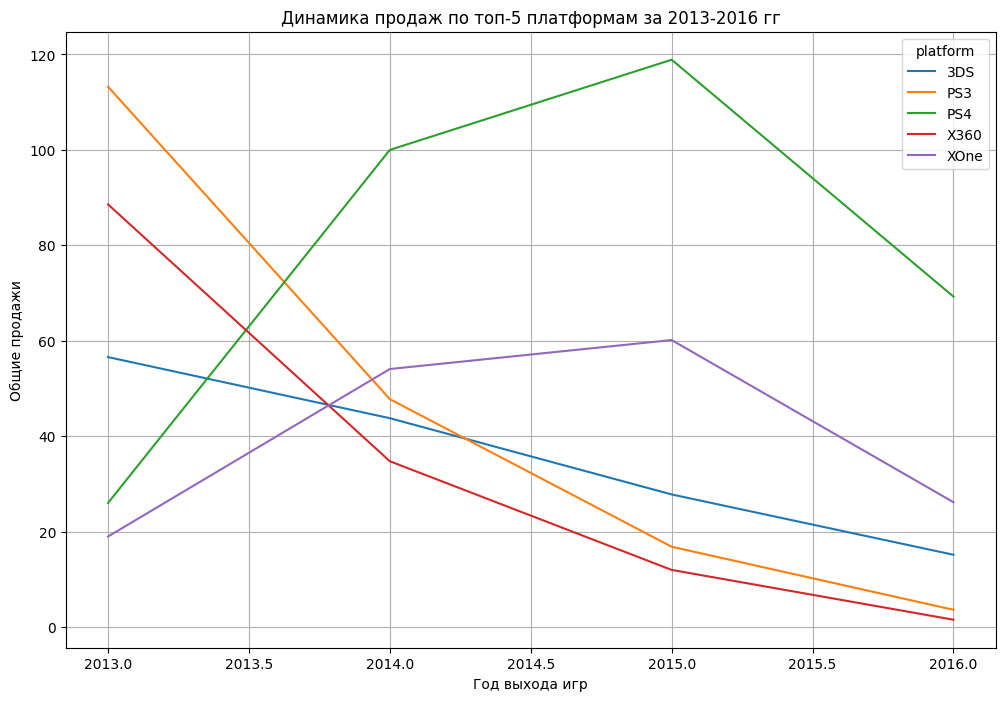

In [30]:
# Создадим таблицу для суммарных продаж по годам и платформам
gr_games = actual_games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# Выберем топ-5 платформ с наибольшими суммарными продажами за всё время
top_platforms = gr_games.groupby('platform')['total_sales'].sum().nlargest(5).index

# Отфильтруем данные для этих платформ
top_gr_games = gr_games[gr_games['platform'].isin(top_platforms)]

# Построим график с использованием seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=top_gr_games, x='year_of_release', y='total_sales', hue='platform')
plt.xlabel('Год выхода игр')
plt.ylabel('Общие продажи')
plt.title('Динамика продаж по топ-5 платформам за 2013-2016 гг')
plt.grid(True)
plt.show()

Лидеры продаж за 2013-2016 года - 3DS, PS3, X360, однако, продажи всех этих платформ пошли на спад, и, скорее всего, через пару лет игры для этих платформ не будут выпускать вовсе. Наиболее перспективными кажутся новые платформы со средними объемами продаж - PS4, XOne.

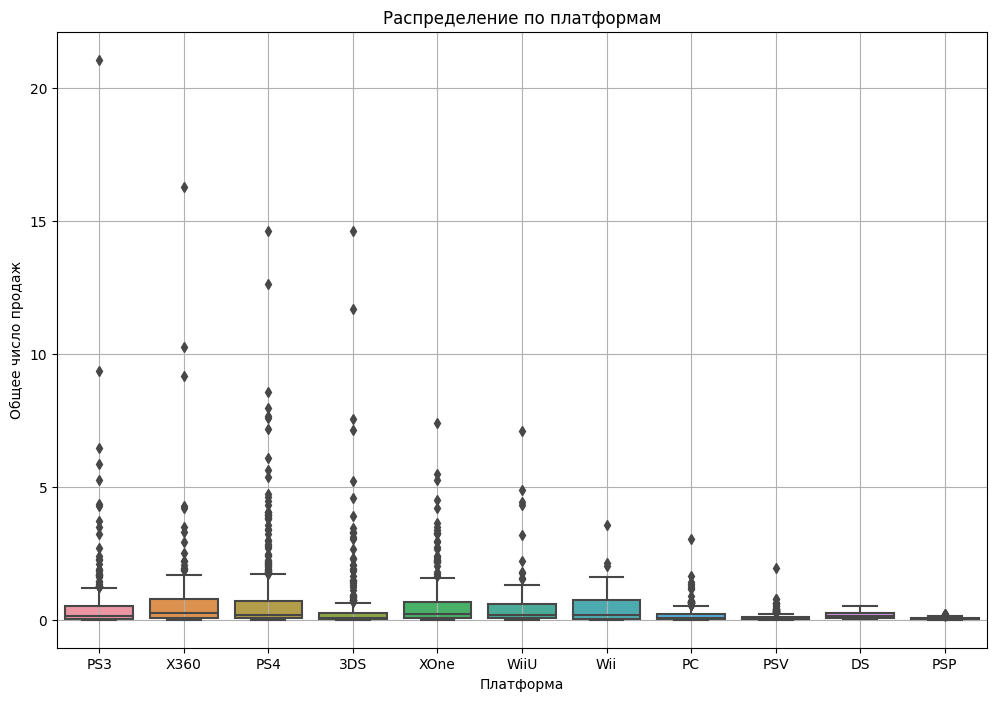

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(x = actual_games['platform'], y = actual_games['total_sales'] );
plt.title('Распределение по платформам')
plt.xlabel('Платформа')
plt.ylabel('Общее число продаж')
plt.grid(True)

На текущем графике медиана и 75% квантиль не видны из-за присутствия выбросов. Чтобы сделать более точные выводы, построим дополнительный график, ограничив ось Y до 2 млн:

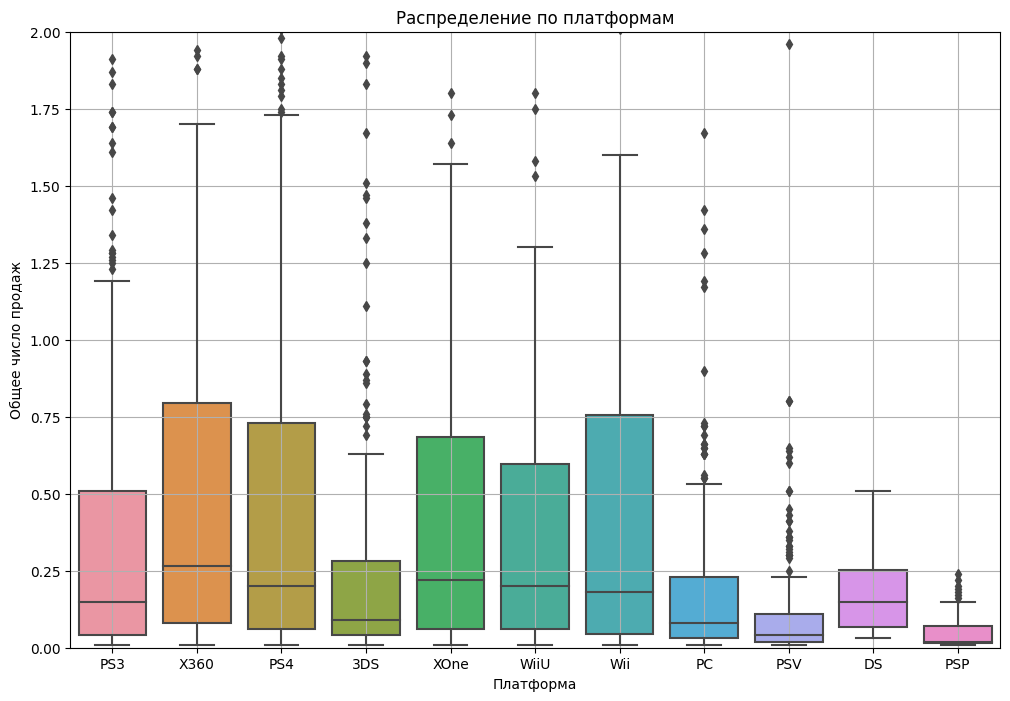

In [32]:
plt.figure(figsize=(12, 8))
sns.boxplot(x = actual_games['platform'], y = actual_games['total_sales']);
plt.ylim((0,2))
plt.title('Распределение по платформам')
plt.xlabel('Платформа')
plt.ylabel('Общее число продаж')
plt.grid(True)

Игры с числом продаж больше 5 млн - редкое явление, однако, такие игры не являются аномалиями: в игровой индустрии действительно могут быть игры с очень большими объемами продаж. 

Наиболее перспектинвые платформы  - PS4 и X360: их продажи стабильно высокие.

Самые популряные платформы, кроме 3DS, распределены одинаково: медиана около 0.25, межкваритльный размах от 0.1 до 0.7.

Продажи 3DS нестабильны: межкваритльный размах озватывает только 0.7 млн продаж. 

---

Посмотрим, как влияют на продажи внутри пяти самых популярных платформ отзывы пользователей и критиков. Для этого создадим датфрейм info, который будет содержать информацию о играх платформы за акутальный период, у которых нет пропуков в оценках пользователей и критиков.

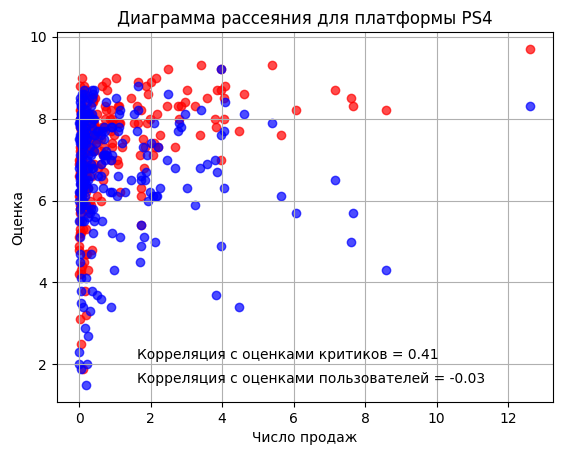

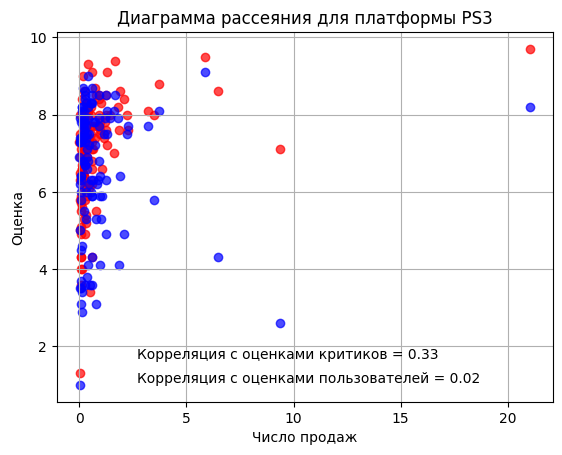

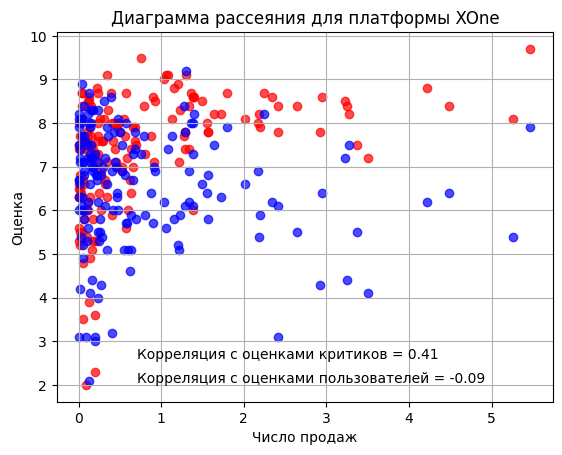

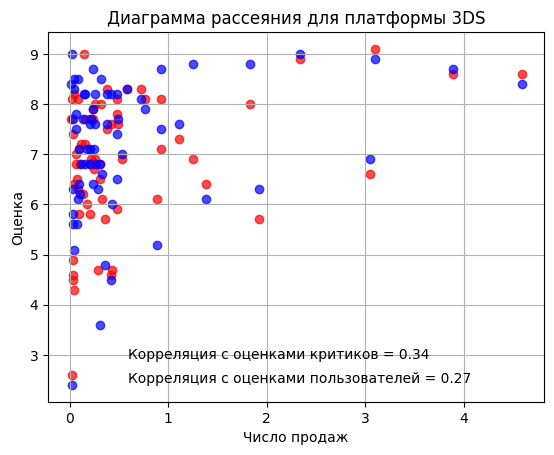

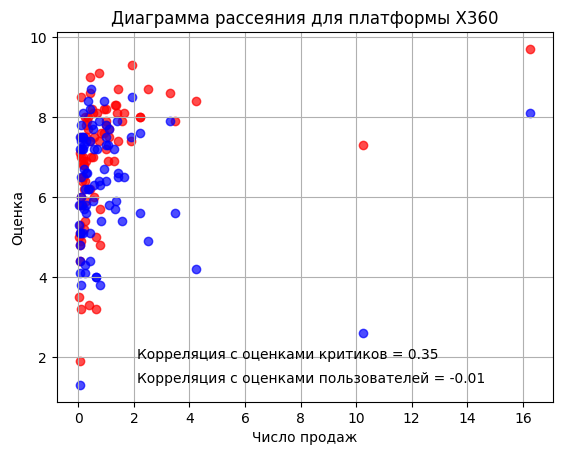

In [33]:
def correlation(plat):
    info = actual_games.loc[(actual_games['platform'] == plat) & (actual_games['critic_score'] > 0) & (actual_games['user_score'] > 0)]
    plt.scatter(info['total_sales'], info['critic_score'], alpha = 0.7, color = 'red')
    plt.xlabel('Число продаж')
    plt.ylabel('Оценка')
    plt.title(f'Диаграмма рассеяния для платформы {plat}')
    plt.grid(True)
    corr = info['total_sales'].corr(info['critic_score']).round(2)
    plt.figtext(x =0.25, y =0.2, s = f'Корреляция с оценками критиков = {corr}')
    
    plt.scatter(info['total_sales'], info['user_score'], alpha = 0.7, color = 'blue')
    corr = info['total_sales'].corr(info['user_score']).round(2)
    plt.figtext(x =0.25, y =0.15, s = f'Корреляция с оценками пользователей = {corr}')
    plt.show()

top_platforms = actual_games.groupby('platform')['total_sales'].sum().nlargest(5).index
for platform in top_platforms:
    correlation(platform)

Зависимость числа продаж от оценок критиков очень слабая: коэффициент корреляции Пирсона 0.3-0.4. Прямой зависимости между числом продаж и оценкой пользователей нет: коэффициент корреляции Пирсона по модулю не больше 0.27 (в основном, близко к нулю), однако, на диаграмме рассеивания видно, что у игр с числом продаж больше 2 млн почти нет оценок критиков и пользователей ниже 5.

---

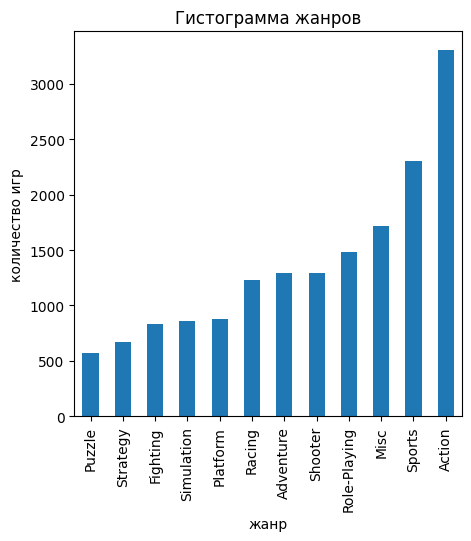

In [34]:
good_games['genre'] .value_counts(ascending = True).plot(kind = 'bar', title = 'Гистограмма жанров', ylabel = 'количество игр', xlabel = 'жанр', figsize=(5,5));

Среди жанров можно выделить наиболее популярный - Action, и наименее популярный - Puzzle.

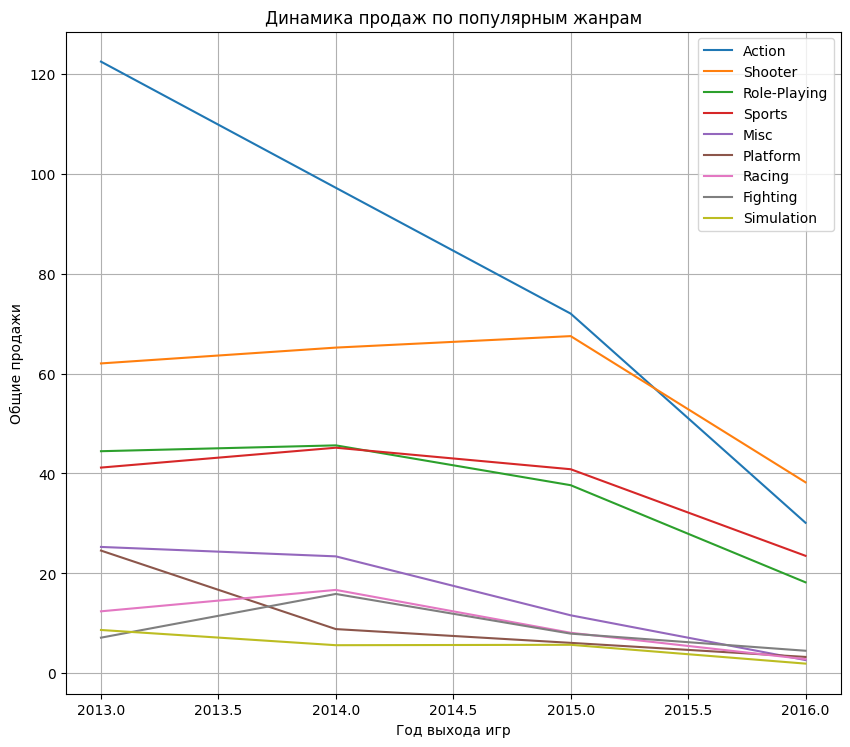

In [35]:
gr_games = actual_games.groupby(['genre', 'year_of_release'])['total_sales'].sum().reset_index()
gr_best_games = gr_games.sort_values('total_sales', ascending = False).head(25)
plt.figure(figsize=(10, 8.6))
for genre in gr_best_games['genre'].unique():
    genre_data = gr_games[gr_games['genre'] == genre]
    plt.plot(genre_data['year_of_release'], genre_data['total_sales'], label=genre)

plt.xlabel('Год выхода игр')
plt.ylabel('Общие продажи')
plt.title('Динамика продаж по популярным жанрам')
plt.legend()
plt.grid(True)
plt.show()

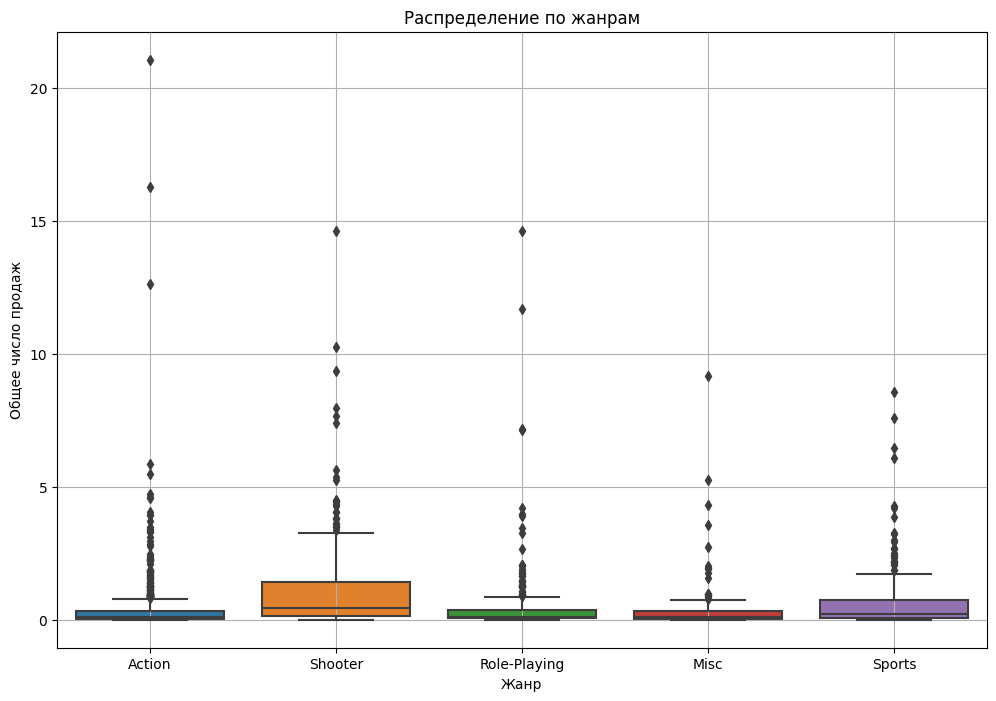

In [36]:
top_genres = actual_games.groupby('genre')['total_sales'].sum().nlargest(5).index
plt.figure(figsize=(12, 8))
sns.boxplot(x = actual_games.query('genre in @top_genres')['genre'], y = actual_games.query('genre in @top_genres')['total_sales'] );
plt.title('Распределение по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Общее число продаж')
plt.grid(True)
plt.show()

Жанр Shooter наиболее перспективный и прибыльный: медиана его продаж больше медиан остальных поплуряных игр, и межквартильный размах охватывает большие значения. 

# Портрет пользователей
<a id='4'></a>

In [37]:
i = 0
def translate(reg):
    if reg == 'eu_sales': return 'Продажи в Европе'
    if reg == 'na_sales': return 'Продажи в Северной Америке'
    if reg == 'jp_sales': return 'Продажи в Японии'
    if reg == 'other_sales': return 'Продажи в других странах'

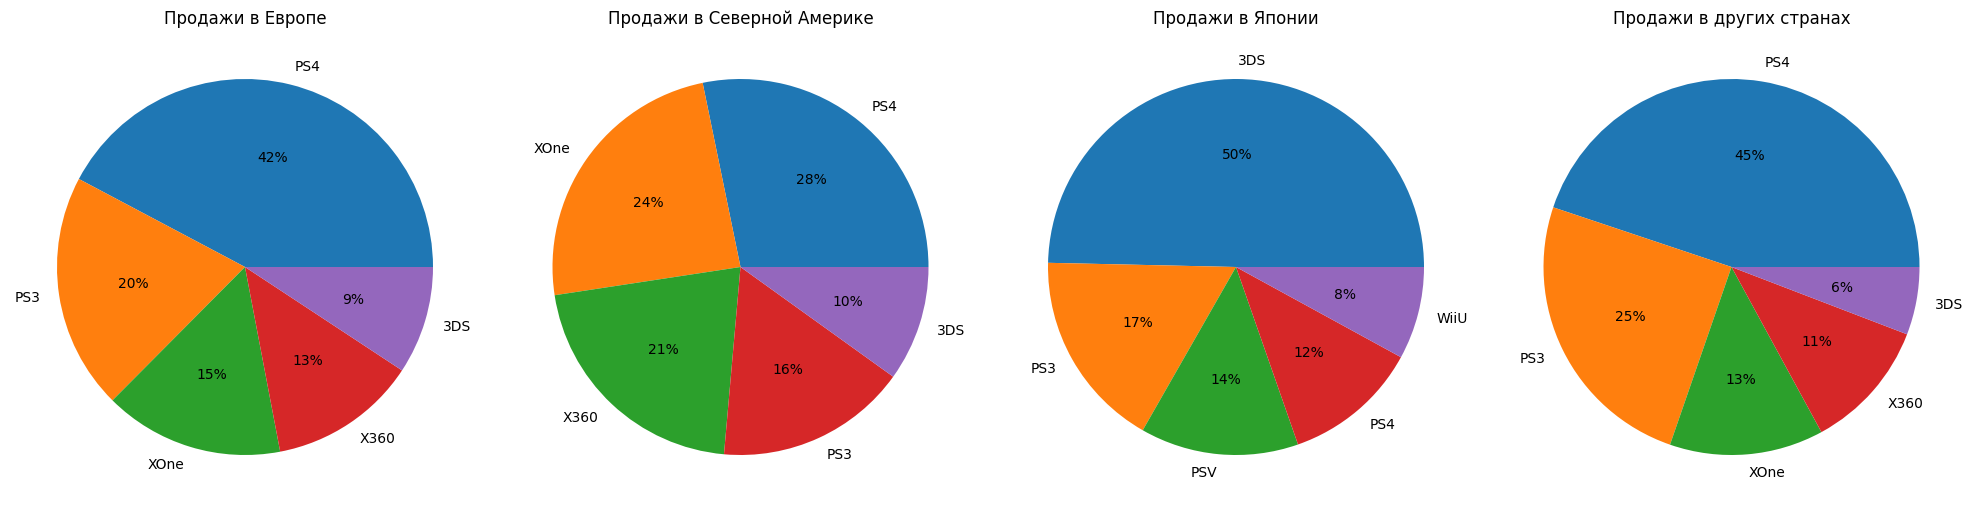

In [38]:
# Определяем количество диаграмм
regions = ['eu_sales', 'na_sales', 'jp_sales', 'other_sales']
n = len(regions)

# Создаем фигуру с несколькими субплотами в одной строке
fig, axes = plt.subplots(1, n, figsize=(20, 5))

# Строим круговые диаграммы на каждом субплоте
for i, reg in enumerate(regions):
    translation = translate(reg) 
    sales_info = actual_games.groupby('platform').agg({reg: 'sum'}).sort_values(reg, ascending=False).head(5)
    sales_info[reg].plot(kind='pie', ax=axes[i], ylabel='', title=translation, autopct='%1.0f%%')

plt.tight_layout()  # Автоматически регулирует параметры подгонки
plt.show()

Анализ платформ по регионам: 
- в Европе лидирует PS4, на втором месте PS3;
- в Северной Америке сразу 3 популряных платформы: PS4, XOne, X360;
- самая популярная платформа в Японии - 3DS, далее с болшим отрывом идет PS3;
- в других странах лидирует PS4.

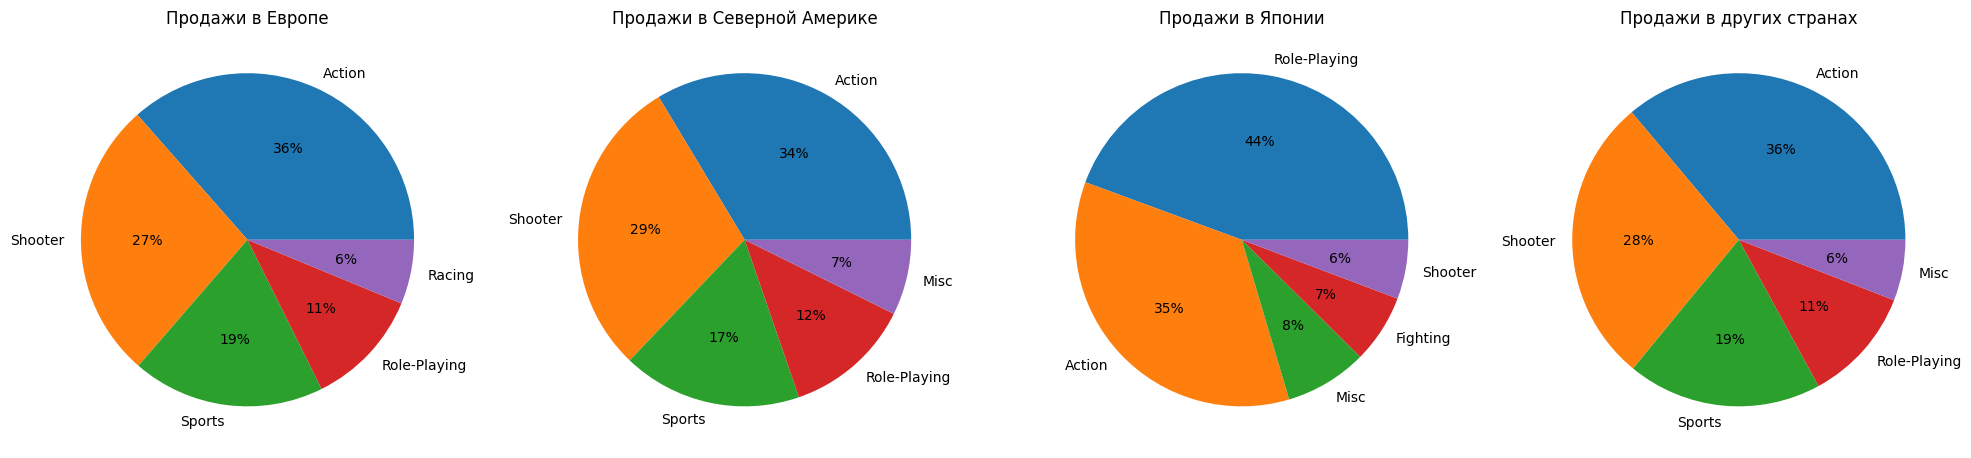

In [39]:
# Определяем количество диаграмм
regions = ['eu_sales', 'na_sales', 'jp_sales', 'other_sales']
n = len(regions)

# Создаем фигуру с несколькими субплотами в одной строке
fig, axes = plt.subplots(1, n, figsize=(20, 5))

# Строим круговые диаграммы на каждом субплоте
for i, reg in enumerate(regions):
    translation = translate(reg) 
    sales_info = actual_games.groupby('genre').agg({reg: 'sum'}).sort_values(reg, ascending=False).head(5)
    sales_info[reg].plot(kind='pie', ax=axes[i], ylabel='', title=translation, autopct='%1.0f%%')

plt.tight_layout()  # Автоматически регулирует параметры подгонки
plt.show()

Анализ жанров по регионам:
- значительную долю рынка во всех регионах, кроме Японии занимает жанр Action;
- в Северной Америке, Европе и других странах второе место занимает Shooter;
- в Японии наиболее популярны игры жанра Role-Playing, а Action толлько на втором месте;
---

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [40]:
rating_data = actual_games.groupby(['rating']).agg({'eu_sales': 'sum', 'jp_sales':'sum', 'na_sales':'sum', 'other_sales':'sum'})

In [41]:
rating_data

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,83.36,15.14,79.05,22.61
E10+,42.69,5.89,54.24,12.57
M,145.32,14.11,165.21,47.04
T,41.95,20.59,49.79,14.29
Unknown,78.91,85.05,89.42,23.46


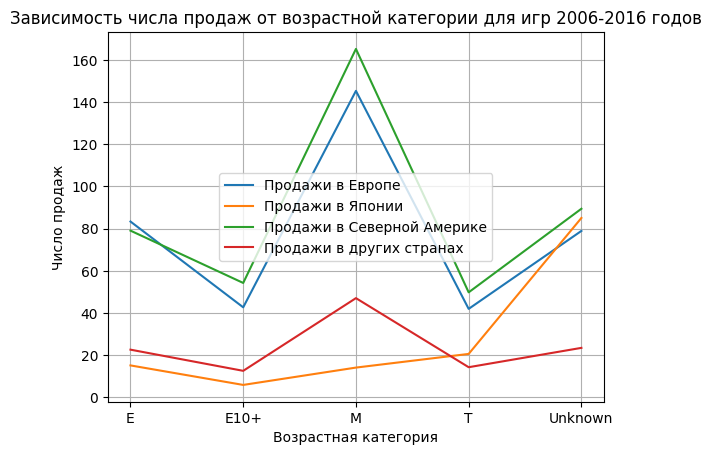

In [42]:
for col in rating_data:
    transaltion = translate(col)
    plt.plot(rating_data[col],label = transaltion);
plt.grid(True)
plt.title('Зависимость числа продаж от возрастной категории для игр 2006-2016 годов')
plt.xlabel('Возрастная категория')
plt.ylabel('Число продаж')
plt.legend()
plt.show;

Расшифровка рейтинга:
- 'E': Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика.
- 'E10+': Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей.
- 'EC': Для детей младшего возраста. Подходит для детей от 3 лет, неприемлемое содержание отсутствует. 
- 'M': Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков.
- 'RP': Категория ещё не присвоена. Играм с категорией RP еще не присвоен окончательный рейтинг ESRB.
- 'T': Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия.

Анализ зависимости числа продаж от возрастной категории:
- для категории E10+ производят меньше всего игр по всему миру;
- в Японии и других странах самая популярная категория - 'T' и чуть менее популрные - 'E' и 'M';
- в Японии, Северной Америке и Европе наибольшее количество игр с неприсвоенным рейтингом.

# Проверка гипотез
<a id='5'></a>

Для проверки гипотез о рейтинагах создадим датафрйем, в котором будет храниться информация об играх, у которых нет пропуска в пользовательском рейтинге и напишем функцию, которая будет проверять гипотезы:

In [43]:
hyp_games = actual_games[actual_games['user_score']>0]

In [44]:
alpha = 0.05 #задаем уровень значимости 

def test_hyp(results):
    print('p-value =', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

---

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [45]:
test_hyp(st.ttest_ind(hyp_games.loc[hyp_games['platform']=='XOne', 'user_score'], hyp_games.loc[hyp_games['platform']=='PC', 'user_score']))

p-value = 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Проверка с помощью t-теста показала, что на основании предоставленных данных нулевую гипотезу отвергнуть не получилось. Нет оснований предполагать о различиях или сходствах средний пользовательских рейтиногов между платформами Xbox One и PC.

---

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

In [46]:
test_hyp(st.ttest_ind(hyp_games.loc[hyp_games['genre']=='Action', 'user_score'], hyp_games.loc[hyp_games['genre']=='Sports', 'user_score']))

p-value = 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Проверка с помощью t-теста показала, что стоит отвергнуть нулевую гипотезу в пользу альтенративной: то есть есть основания предполагать, что средние пользовательские рейтинги жанров Action и Sports разные.

---

# Общий вывод
<a id='6'></a>

В результате предобработки данных:
- названия столбцов приведены к нижнему регистру;
- данные проверены на отсутствие неявных дубликатов;
- удалены игры с одинаковыми названием, платформой и годом выпуска;
- в столбцах продаж удалены аномальные значения;
- обработаны пропуски: заполнение пропусков средним или медианным значением сильно бы исказило дальнейшие выводы, но, с другой стороны, столбцы 'critic_score' и 'user_score' числовые, а из-за наличия значения NaN с ними можно было работать только как с типом object, поэтому пропуски в столбцах 'critic_score' и 'user_score' заполнили значениями -10 и -1 соответственно, а пропуски в столбце 'rating' заменили на 'Unknown'.
- изменили тип данных: столбец 'year_of_release' привели к типу int. В столбце 'user_score' заменили значения 'tbd'(to be determined) на -2 и привели к типу float;
- для более наглядного и удобного сравнения оценки критиков и пользователей разделили значения из  столбца 'critic_score' на 10;

В итоге, осталось 91.5% данных. 

В рамках исследовательского анализа данных был определен характерный срок, за который появляются новые и исчезают старые платформы: 7-10 лет. Для прогнозирования продаж на 2017 год выбран акутальный период: с 2013 по 2016 год. Дальнейшие исследования проводились только на данных за акутальный период. Выводы по ИАД:
- больше всего игр выходило в 2007-2011 годах, после чего количество релизов пошло на спад.
- лидеры продаж за 2013-2016 года - 3DS, PS3, X360, однако, продажи всех этих платформ пошли на спад, и, скорее всего, через пару лет игры для этих платформ не будут выпускать вовсе.
- игры с числом продаж больше 5 млн - редкое явление, однако, такие игры не являются аномалиями: в игровой индустрии действительно могут быть игры с очень большими объемами продаж. Наиболее перспектинвые платформы - PS4 и XOne: их продажи стабильно высокие.
- самые популярные платформы, кроме 3DS, распределены одинаково: медиана около 0.25, межквартильный размах от 0.1 до 0.7. Продажи 3DS нестабильны: межквартильный размах озватывает только 0.7 млн продаж.
- зависимость числа продаж от оценок критиков очень слабая: коэффициент корреляции Пирсона 0.3-0.4. Прямой зависимости между числом продаж и оценкой пользователей нет: коэффициент корреляции Пирсона по модулю не больше 0.27 (в основном, близко к нулю), однако, на диаграмме рассеивания видно, что у игр с числом продаж больше 2 млн почти нет оценок критиков и пользователей ниже 5.
- среди жанров можно выделить наиболее популярный - Action, и наименее популярный - Puzzle.
- жанр Shooter наиболее перспективный и прибыльный: медиана его продаж больше медиан остальных поплуряных игр, и межквартильный размах охватывает большие значения.

Далее было проведено исселовадние по регионам:
- Анализ платформ по регионам: 
    - в Европе лидирует PS4, на втором месте PS3;
    - в Северной Америке сразу 3 популряных платформы: PS4, XOne, X360;
    - самая популярная платформа в Японии - 3DS, далее с болшим отрывом идет PS3;
    - в других странах лидирует PS4.
- Анализ жанров по регионам:
    - значительную долю рынка во всех регионах, кроме Японии занимает жанр Action;
    - в Северной Америке, Европе и других странах второе место занимает Shooter;
    - в Японии наиболее популярны игры жанра Role-Playing, а Action толлько на втором месте;
 
После был поставлен вопрос: Влияет ли рейтинг ESRB на продажи в отдельном регионе? Анализ зависимости числа продаж от возрастной категории показал:
- для категории E10+ производят меньше всего игр по всему миру;
- в Японии, Северной Америке и Европе наибольшее количество игр с неприсвоенным рейтингом;
- в Японии и других странах самая популярная категория - 'T' и чуть менее популрные - 'E' и 'M'.

Далее было проверено две гипотезы с уровнем статистической значимости 0.05:
- нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Проверка с помощью t-теста показала, что на основании предоставленных данных нулевую гипотезу отвергнуть не получилось. Нет оснований предполагать о различиях или сходствах средний пользовательских рейтиногов между платформами Xbox One и PC.
- Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые. Проверка с помощью t-теста показала, что стоит отвергнуть нулевую гипотезу в пользу альтенративной: то есть есть основания предполагать, что средние пользовательские рейтинги жанров Action и Sports разные.

Рекомендации по улучшению качества данных и направления дальнейших исследований:
- на примере Японии видно, что общая картина по многим параметрам отличается от Америки и Европы. Можно добавить больше крупных стран Азии и исследовать рынок отдельно;
- вложиться стоит в игры жанра Shooter: они наиболее прибыльные и стабильные;
- наиболее перспективные платформы - PS4, XOne. Также в будущем стоит обратить внимание на новые версии популярных платформ (линейнки PS и Xbox)